In [94]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans
from queue import  Queue

In [95]:
class ImageProcessing(object):
    
    @staticmethod
    def reverse(img):
        n_img = img.copy()
        n_img[img==0] = 255
        n_img[img==255] = 0
        return  n_img
        
    @staticmethod
    def closing(img,kernel_size = 3):
        img = ImageProcessing.reverse(img)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)  # 闭运算  
        img = ImageProcessing.reverse(img)
        return  img
        
    @staticmethod
    def opening(img,kernel_size = 3):
        img = ImageProcessing.reverse(img)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # 开运算  
        img = ImageProcessing.reverse(img)
        return  img
    
    @staticmethod
    def erode(img,kernel_size = 3):
        img = ImageProcessing.reverse(img)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        img = cv2.erode(img, kernel)
        img = ImageProcessing.reverse(img)
        return  img
    
    @staticmethod
    def dilate(img,kernel_size = 3):
        img = ImageProcessing.reverse(img)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        img = cv2.dilate(img, kernel)
        img = ImageProcessing.reverse(img)
        return  img
    
    @staticmethod
    def delete_spot(img, max_len = 10):
        """
        将与边框粘连的长宽小于max_len的块去掉,本问题中只需要考虑左右边框即可
        :param img:需要处理的图像 
        :param max_len: 
        :return: 
        """
        flag = np.zeros(img.shape)
        y = 0 #先处理左边框
        for x in range(img.shape[0]):
            if img[x][y] == 0 and flag[x][y] == 0:
                img, flag = ImageProcessing.__bfs(img, flag,(x,y),max_len)
            
        y = img.shape[1] - 1  #先处理左边框
        for x in range(img.shape[0]):
            if img[x][y] == 0 and flag[x][y] == 0:
                img, flag = ImageProcessing.__bfs(img, flag,(x,y),max_len)
        return  img
    
    moves = [(1,0),(-1,0), (0, 1), (0, -1), (1,1), (1, -1),(-1, 1), (-1, -1)]
    @staticmethod
    def __bfs(raw_img, flag,s_point,max_len ): 
        # print(s_point)
        img = raw_img.copy()
        Up, Down, Left , Right = 0, img.shape[0] -1 ,0, img.shape[1] -1
        up, down, left, right = s_point[0], s_point[0],s_point[1], s_point[1]
        Q = Queue()
        Q.put(s_point)
        flag[s_point[0],s_point[1]] =1
        while not Q.empty():
            x,y = Q.get()
            for _x,_y in ImageProcessing.moves:
                new_x = x + _x
                new_y = y + _y
                if new_x < Up or new_x >Down or \
                        new_y < Left or new_y > Right or \
                        img[new_x,new_y] != 0:
                    continue
                flag[new_x,new_y] =1 
                img[new_x, new_y] = 255
                Q.put((new_x, new_y))
                up = min(up, new_x)
                down = max(down, new_x)
                left = min(left, new_y)
                right = max(right, new_y)
        if down - up + 1 >= max_len or right - left + 1 >= max_len:
            return  raw_img,flag
        else :
            return  img,flag
                
        

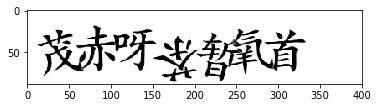

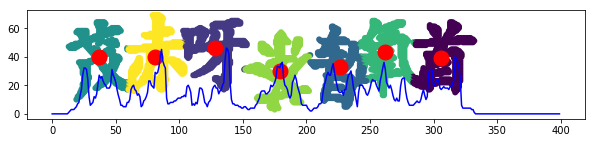

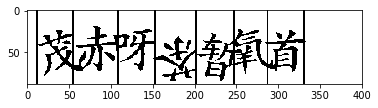

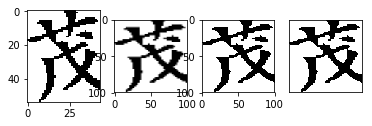

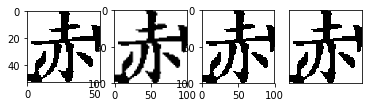

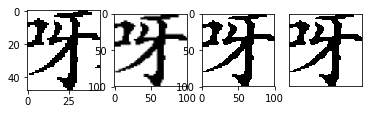

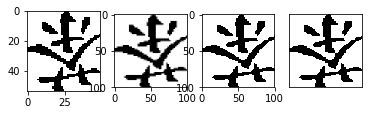

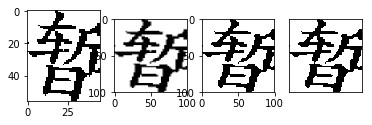

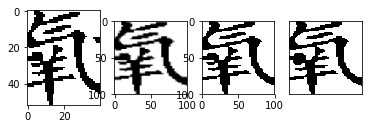

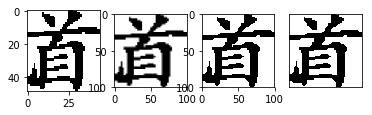

words: (7, 100, 100)
words: (7, 100, 100)
words: (7, 100, 100)
words: (7, 100, 100)
words: (7, 100, 100)


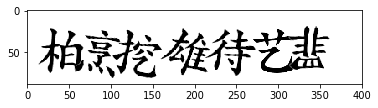

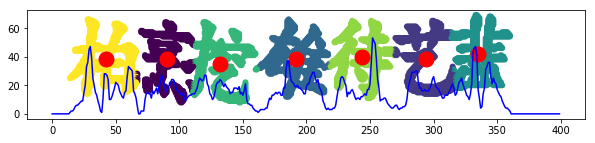

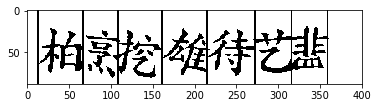

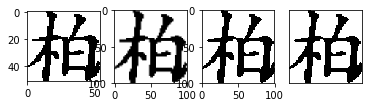

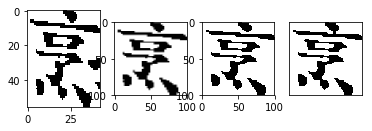

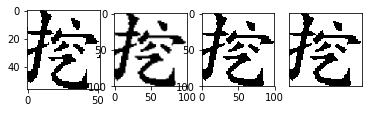

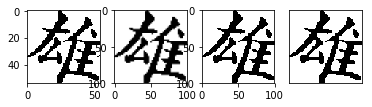

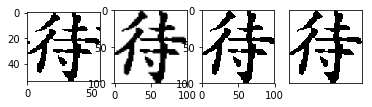

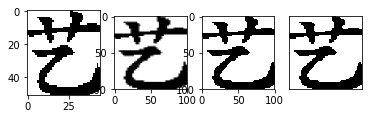

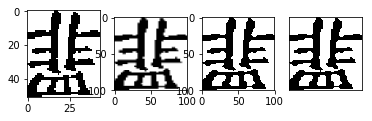

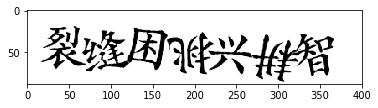

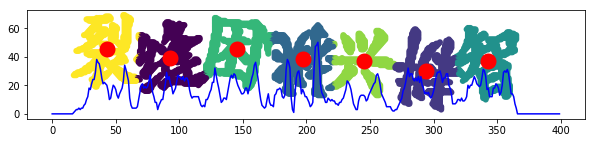

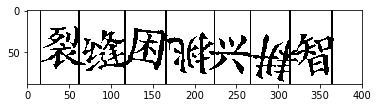

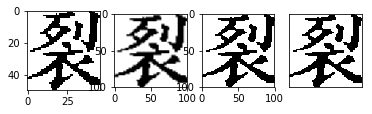

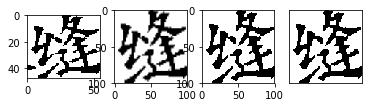

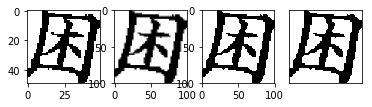

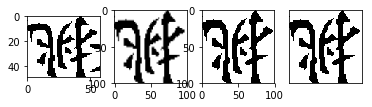

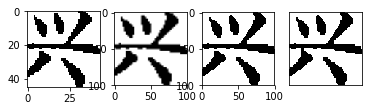

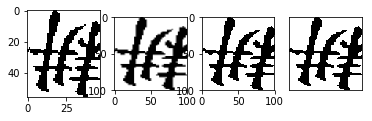

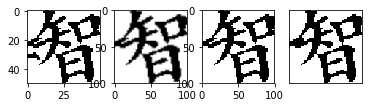

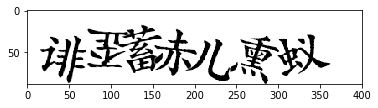

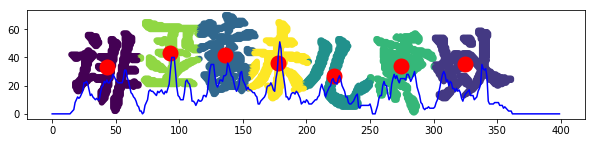

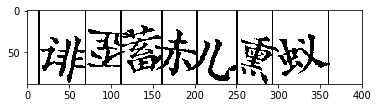

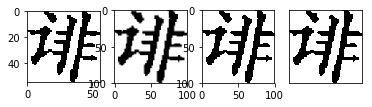

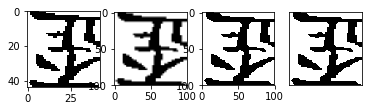

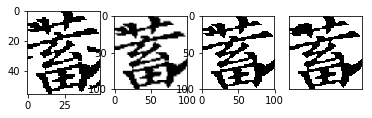

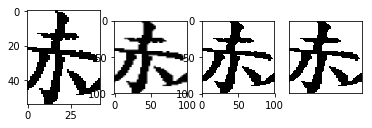

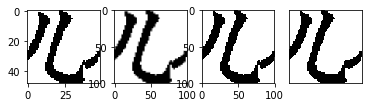

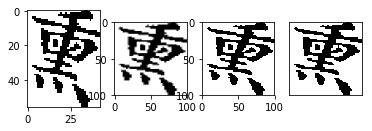

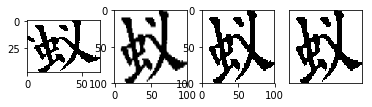

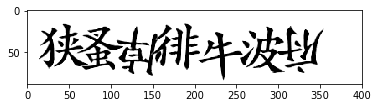

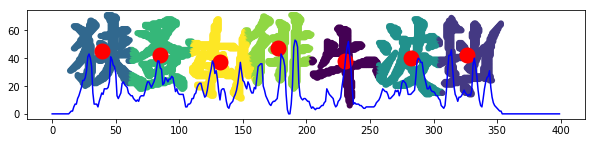

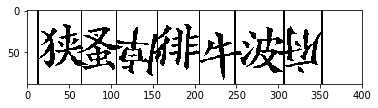

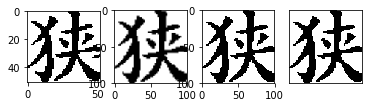

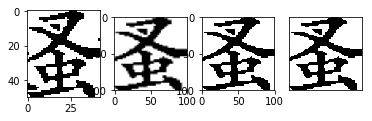

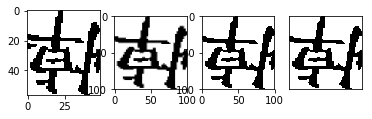

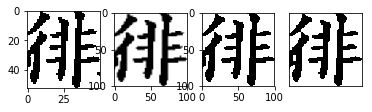

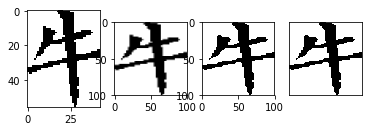

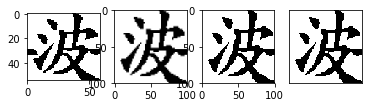

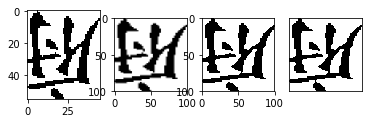

In [99]:


class Captha2Words(object):
    
    def __init__(self, k,weight, height):
        self.weight = weight
        self.height = height
        self.k = k
    
    def run(self, img_path):
        """
        
        :param img_path: 
        :return: narray shape = (k,height, weight) 
        """
        img, PIL_img = self.get_img(img_path)
        centers = self.Kmeans(img)
        self.plot_centers(PIL_img,centers)
        words = self.test(img, centers)
        return  words
    
    def test(self, raw_img, centers):
        # plt.imshow(img,cmap='gray') 
        # plt.show()
        img = raw_img.copy()
        count = np.sum(img == 0,axis= 0)
        left_boundary,right_boundary = 0,0
        for i in range(img.shape[1]):
            if count[i] != 0 :
                left_boundary = i
                break
        for i in range(img.shape[1]-1,-1,-1):
            if count[i] != 0 :
                right_boundary = i
                break
        # print(left, right)
        min_quarter = (right_boundary - left_boundary)//self.k//4
        min_weight = (right_boundary - left_boundary)//self.k *7 //8
        
        left = left_boundary + min_weight
        split_lines = [left_boundary]#字符之间的分割线位置
        for i in range(self.k - 1):
            right = centers[i+1][1] - min_quarter
            if left > right :
                minx = 0
            else :
                minx = np.argmin(count[left:right])
            line = left + minx 
            img = self.plot_line(img,line)
            left = line + min_weight
            split_lines.append(line)
        split_lines.append(right_boundary)
        img = self.plot_line(img,left_boundary)
        img = self.plot_line(img,right_boundary)
        plt.imshow(img,cmap='gray')
        plt.show()
        words = self.get_words(raw_img,split_lines)
        return  words
    
    def get_words(self,img, split_lines):
        words = np.zeros((self.k,self.height, self.weight))
        for i in range(self.k):
            words[i,:,:] = self.get_word(img[:,split_lines[i]:split_lines[i+1]])
        return  words
    
    def get_word(self,img):
        # plt.imshow(img,cmap="gray")
        # plt.show()
        count = np.sum(img==0, axis= 1)
        # print(count)
        up ,down = 0,0
        for i in range(img.shape[0]):
            if count[i] != 0:
                up = i
                break
        for i in range(img.shape[0]-1,-1,-1):
            if count[i] != 0:
                down = i
                break
        word1 = img[up:down,:] 
        word2 = ImageProcessing.delete_spot(word1)
        word2 = cv2.resize(word2, (self.height, self.weight))
        th,word3= cv2.threshold(word2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        word4 = ImageProcessing.closing(word3)
        fig,ax = plt.subplots(1,4)
        ax[0].imshow(word1, cmap="gray")
        ax[1].imshow(word2, cmap="gray")
        ax[2].imshow(word3, cmap="gray")
        ax[3].imshow(word4, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.show()
        return  word4
        
    def plot_line(self, img, line):
        img = img.copy()
        img[:,line-2:line] = 0
        return  img
    
    def Kmeans(self,img):
        X = self.get_black_point(img)
        plt.figure(figsize=(10,2))
        km = KMeans(n_clusters=self.k)
        y_pred = km.fit_predict(X)
        centers = km.cluster_centers_
        centers = np.asarray(centers,dtype = np.int16)
        centers = centers[np.argsort(centers[:,1])]
        # print(centers)
        plt.scatter(X[:,1], 88-X[:,0], c = y_pred, linewidths=0.01)
        plt.scatter(centers[:,1],88-centers[:,0],c='r', linewidths= 10)
        count = np.sum(img == 0,axis= 0)
        plt.plot(count,'b')
        plt.show()
        return  centers
        
    def plot_centers(self, PIL_img, centers):
        im = PIL_img.copy()
        bgdr = ImageDraw.Draw(im)
        for y, x in centers:
            bgdr.ellipse((x-3, y-3, x+3, y+3), fill ="red", outline ='red')
        # im.show()
        # print(im) 
        
    def split(self,img):
        pass
        
    def get_img(self,img_path):
        PIL_img = Image.open(img_path)
        img =np.asarray(PIL_img.convert("L"))#转化为灰度图像 
        img.setflags(write=1)
        plt.imshow(img,cmap="gray")
        plt.show()
        # uniques, counts = np.unique(img, return_counts=True)
        # print(uniques)
        # plt.scatter(uniques, counts)
        # plt.show()
        
        th,img= cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # img[img<=150] = 0
        # img[img>150]=255
        # plt.imshow(img,cmap="gray")
        # plt.show()
        
        return img, PIL_img.convert('RGB')
    
    def get_black_point(self, img):
        len = np.sum(img == 0)
        X = np.zeros((len,2))
        cnt = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i][j] == 0:
                    X[cnt,0],X[cnt,1] = i,j
                    cnt =cnt +1
        return X
        
if __name__ == '__main__':
    img_dir = r'.\CaptchaData'
    k = 7#字符个数
    weight =100
    height = 100
    get_words = Captha2Words(k,weight, height)
    for img_name in (os.listdir(img_dir))[:5]:
        img_path = os.path.join(img_dir, img_name)
        words = get_words.run(img_path)
        print("words:",words.shape)
        